In [1]:
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.stats as s
import scipy.special as ss
import sortedcontainers as sc
import os
import tqdm

In [2]:
os.environ["CAPY_REF_FA"] = "/home/opriebe/data/ref/hg19/Homo_sapiens_assembly19.fasta"
import hapaseg.coverage_MCMC as mcmc_cov
import hapaseg.NB_coverage_MCMC as nb_cov
from capy import mut, seq

Cannot find path to gnomAD index; gnomAD functionality disabled.


Load MCMC trace over SNP DP cluster assignments. Still looking at only the high purity exome

In [3]:
colors = mpl.cm.get_cmap("tab10").colors

### Load coverage

In [4]:
Cov = pd.read_csv("exome/6_C1D1_META.cov", sep = "\t", names = ["chr", "start", "end", "covcorr", "covraw"], low_memory=False)
Cov["chr"] = mut.convert_chr(Cov["chr"])
Cov = Cov.loc[Cov["chr"] != 0]
Cov["start_g"] = seq.chrpos2gpos(Cov["chr"], Cov["start"])
Cov["end_g"] = seq.chrpos2gpos(Cov["chr"], Cov["end"])

### Load covariates

In [5]:
Cov["C_len"] = Cov["end"] - Cov["start"] + 1

# load repl timing
F = pd.read_pickle("covars/GSE137764_H1.hg19_liftover.pickle")

# map targets to RT intervals
tidx = mut.map_mutations_to_targets(Cov.rename(columns = { "start" : "pos" }), F, inplace = False)
Cov.loc[tidx.index, "C_RT"] = F.iloc[tidx, 3:].mean(1).values

# z-transform
Cov["C_RT_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_RT"] + 1e-20))

#load GC content
B = pd.read_pickle("covars/GC.pickle")
Cov = Cov.merge(B.rename(columns = { "gc" : "C_GC" }), left_on = ["chr", "start", "end"], right_on = ["chr", "start", "end"], how = "left")
Cov["C_GC_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_GC"] + 1e-20))

In [6]:
clust = np.load("exome/6_C1D1_META.DP_clusts.auto_ref_correct.overdispersion92.no_phase_correct.npz")

#### Load chromosome boundary coordinates

In [7]:
allelic_segs = pd.read_pickle("exome/6_C1D1_META.allelic_segs.auto_ref_correct.overdispersion92.no_phase_correct.pickle")
chrbdy = allelic_segs.dropna().loc[:, ["start", "end"]]
chr_ends = chrbdy.loc[chrbdy["start"] != 0, "end"].cumsum()

In [8]:
clust["snps_to_clusters"].shape

(500, 11768)

In [9]:
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

### load SNPs from single DP iteration

In [10]:
iter_ind = 499
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

#assign coverage intervals to clusters
Cov_clust_probs = np.zeros([len(Cov), clust_u.max()])

for targ, snp_idx in SNPs.groupby("tidx").indices.items():
    targ_clust_hist = np.bincount(clust_uj[499, snp_idx].ravel(), minlength = clust_u.max())

    Cov_clust_probs[int(targ), :] = targ_clust_hist/targ_clust_hist.sum()

#subset intervals containing SNPs
overlap_idx = Cov_clust_probs.sum(1) > 0
Cov_clust_probs_overlap = Cov_clust_probs[overlap_idx, :]

#prune improbable assignments
Cov_clust_probs_overlap[Cov_clust_probs_overlap < 0.05] = 0
Cov_clust_probs_overlap /= Cov_clust_probs_overlap.sum(1)[:, None]
prune_idx = Cov_clust_probs_overlap.sum(0) > 0
Cov_clust_probs_overlap = Cov_clust_probs_overlap[:, prune_idx]

In [11]:
import scipy.stats
assgn_entropy = scipy.stats.entropy(Cov_clust_probs_overlap, axis=1)
entropy_idx = (assgn_entropy == 0)

#subsetting to only targets that overlap SNPs
Cov_overlap = Cov.loc[overlap_idx, :]

#subsetting to only targets with hard assignments
Cov_overlap = Cov_overlap.loc[entropy_idx,:]

r = np.c_[Cov_overlap["covcorr"]]

#making covariate matrix
C = np.c_[np.log(Cov_overlap["C_len"]), Cov_overlap["C_RT_z"], Cov_overlap["C_GC_z"]]

Pi = Cov_clust_probs_overlap[entropy_idx,:].copy()

#dropping Nans
naidx = np.isnan(C[:, 1])
r = r[~naidx]
C = C[~naidx]
Pi = Pi[~naidx]

Cov_overlap = Cov_overlap.iloc[~naidx]

mu = np.log(r.mean()*np.ones([Pi.shape[1], 1])) / 2
beta = np.ones([C.shape[1], 1])
mu_i = np.zeros(C.shape[0])
epsi = np.ones((mu.shape)) *2

Cov_overlap['cluster_assgn'] = np.argmax(Pi, axis=1)

almost all bins are unanimously assigned

In [12]:
#subsetting to only targets that overlap SNPs
Cov_overlap = Cov.loc[overlap_idx, :]

#subsetting to only targets with hard assignments
Cov_overlap = Cov_overlap.loc[entropy_idx,:]

r = np.c_[Cov_overlap["covcorr"]]

#making covariate matrix
C = np.c_[np.log(Cov_overlap["C_len"]), Cov_overlap["C_RT_z"], Cov_overlap["C_GC_z"]]

Pi = Cov_clust_probs_overlap[entropy_idx,:].copy()

In [13]:
#dropping Nans
naidx = np.isnan(C[:, 1])
r = r[~naidx]
C = C[~naidx]
Pi = Pi[~naidx]

In [14]:
Cov_overlap = Cov_overlap.iloc[~naidx]

In [15]:
mu = np.log(r.mean()*np.ones([Pi.shape[1], 1])) / 2
beta = np.ones([C.shape[1], 1])
mu_i = np.zeros(C.shape[0])
epsi = np.ones((mu.shape)) *2

In [16]:
Cov_overlap['cluster_assgn'] = np.argmax(Pi, axis=1)

In [17]:
cov_18 = Cov_overlap.loc[Cov_overlap['cluster_assgn'] == 18]
r_18 = np.c_[cov_18["covcorr"]]

#making covariate matrix
C_18 = np.c_[np.log(cov_18["C_len"]), cov_18["C_RT_z"], cov_18["C_GC_z"]]

In [18]:
nb_mcmc = nb_cov.NB_MCMC(r, C, Pi)

In [19]:
def scipy_ll(in_r, in_mu, in_C, in_beta, in_epsi_i, in_mu_i):
    in_r = in_r.flatten()
    in_mu= in_mu.flatten()
    in_epsi_i = in_epsi_i.flatten()
    in_mu_i = in_mu_i.flatten()
    exp = np.exp(in_mu + in_C @ in_beta + in_mu_i).flatten()
    return scipy.stats.nbinom.logpmf(in_r, in_epsi_i, (1-(exp / (exp + in_epsi_i)))).sum(0)

In [20]:
def ll_cluster(in_r, in_mu, in_C, in_beta, in_epsi_i, in_mu_i):
    in_r = in_r.flatten()
    in_mu= in_mu.flatten()
    in_epsi_i = in_epsi_i.flatten()
    in_mu_i = in_mu_i.flatten()
    bc = (in_C @ in_beta).flatten()
    
    exp = np.exp(in_mu + bc + in_mu_i).flatten()
    return (ss.gammaln(in_r + in_epsi_i) - ss.gammaln(in_r + 1) - ss.gammaln(in_epsi_i) + (in_r * (in_mu + bc + in_mu_i - np.log(in_epsi_i + exp))) + (in_epsi_i * (np.log(in_epsi_i) - np.log(in_epsi_i + exp))))

In [21]:
mu_i = np.zeros(40)

In [54]:
res = []
statsres = []
leps = np.r_[-100:40:0.1]
for lep in leps:
    res.append(ll_cluster(r_18[0], nb_mcmc.clusters[18].mu, nb_mcmc.clusters[18].C[0,:], nb_mcmc.clusters[18].beta, np.exp(lep), mu_i[0]))
    statsres.append(scipy_ll(r_18[0], nb_mcmc.clusters[18].mu, nb_mcmc.clusters[18].C[0,:], nb_mcmc.clusters[18].beta, np.exp(lep), mu_i[0]))

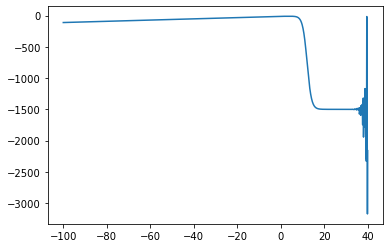

In [55]:
plt.plot(leps, res)

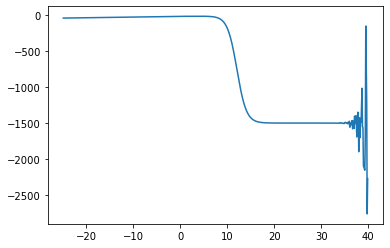

In [56]:
plt.plot(leps, statsres)

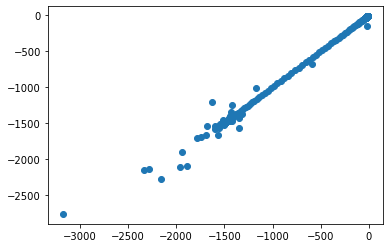

In [58]:
plt.scatter(res, statsres)

In [74]:
res = []
statsres = []
leps = np.r_[-10:40:0.1]
for lep in leps:
    res.append(ll_cluster(r_18.flatten(), nb_mcmc.clusters[18].mu, nb_mcmc.clusters[18].C, nb_mcmc.clusters[18].beta, np.exp(lep), mu_i).sum())
    #statsres.append(scipy_ll(r_18.flatten(), nb_mcmc.clusters[18].mu, nb_mcmc.clusters[18].C, nb_mcmc.clusters[18].beta, np.exp(lep), mu_i))

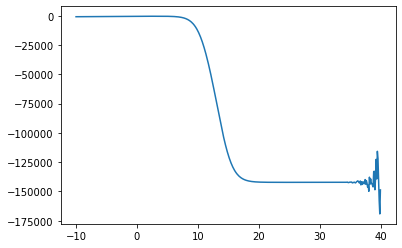

In [75]:
plt.plot(leps, res)

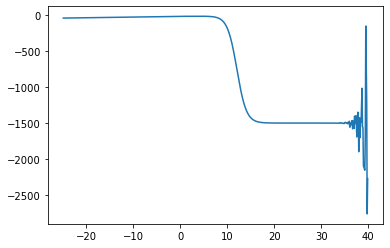

In [56]:
plt.plot(leps, statsres)

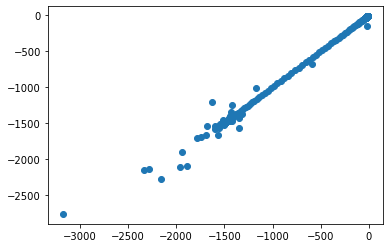

In [58]:
plt.scatter(res, statsres)

need to cutoff epsilon at ~35

In [25]:
def NR_segment(self, ind, ret_hess=False):
    # start by setting mu_i to the average of the residuals
    mui_init = np.log(np.exp(np.log(self.r[ind[0]:ind[1]]) - (self.mu) - 
        (self.C[ind[0]:ind[1],:]@self.beta).flatten()).mean())
    #lepsi_init = np.log((((np.log(self.r[ind[0]:ind[1]]) - self.mu)**2 / self.mu - 1)).sum() / (ind[1]-ind[0]))
    self.mu_i = mui_init
    self.lepsi_i = self.lepsi_i_arr[ind[0]]
    cur_iter = 0
    max_iter = 50
    while(cur_iter < max_iter):
        self.epsi_i = np.exp(self.lepsi_i)
        self.exp = np.exp(self.mu + (self.C[ind[0]:ind[1]] @ self.beta).flatten() + self.mu_i)

        gmu_i = self.gradmu_i(ind)
        hmu_i = self.hessmu_i(ind)
        gepsi_i = self.gradepsi_i(ind)
        hepsi_i = self.hessepsi_i(ind) * self.epsi_i ** 2 + gmu_i * self.epsi_i
        hmuepsi_i = self.hessepsi_i(ind)

        grad = np.r_[gmu_i, gepsi_i * self.epsi_i]
        H = np.r_[np.c_[hmu_i, hmuepsi_i], np.c_[hmuepsi_i, hepsi_i]]

        try:
            inv_H = np.linalg.inv(H)
        except:
            print('reached singular matrix. reseeting with grid search')
            self.lepsi_i = self.ll_gridsearch(ind)
            continue
        delta = inv_H @ grad

        self.mu_i -= delta[0]
        self.lepsi_i -= delta[1]

        if np.isnan(self.mu_i):
            # if we hit a nan try a new initialization
            print('hit a nan in optimizer, reseting')
            self.mu_i = mui_init + np.random.rand() - 0.5
            self.lepsi_i = self.ll_gridsearch(ind)
            continue

        if np.linalg.norm(grad) < 1e-5:
            #print('opt reached')
            #print(np.linalg.det)
            break

        if cur_iter == 25:
            #if its taking this long we should reset with a grid search
            print('failing to converge. Trying grid search')
            self.mu_i = mui_init
            self.lepsi_i = self.ll_gridsearch(ind)

        if cur_iter == 49:
            print('failed to optimize: ', ind)
        cur_iter += 1
    #print(ind, self.mu_i, self.lepsi_i)
    # need to theshold due to overflow
    self.lepsi_i = min(self.lepsi_i, 40)
    if ret_hess:
        return self.mu_i, self.lepsi_i, H
    else:
        return self.mu_i, self.lepsi_i

In [62]:
a, b = nb_mcmc.clusters[1].stats_optimizer((102,125))

In [66]:
c, d = NR_segment(nb_mcmc.clusters[1], (102,125))

In [65]:
nb_mcmc.clusters[1].ll_nbinom(nb_mcmc.clusters[1].r[102:125], nb_mcmc.clusters[1].mu, nb_mcmc.clusters[1].C[102:125], nb_mcmc.clusters[1].beta, np.ones(C[102:125].shape[0]) * a, b)

-221.1154552105259

In [67]:
nb_mcmc.clusters[1].ll_nbinom(nb_mcmc.clusters[1].r[102:125],  nb_mcmc.clusters[1].mu, nb_mcmc.clusters[1].C[102:125],  nb_mcmc.clusters[1].beta, np.ones(C[102:125].shape[0]) * c, d)

-218.40575546656908

In [23]:
a, b = nb_mcmc.clusters[1].stats_optimizer((565,568))
a,b

(-0.07282043852316707, 3.9209187190936334)

In [26]:
c, d = NR_segment(nb_mcmc.clusters[1], (565,568))
c,d

failing to converge. Trying grid search


(-0.07282384320365129, 3.6373922884927286)

In [27]:
nb_mcmc.clusters[1].ll_nbinom(nb_mcmc.clusters[1].r[565:568], nb_mcmc.clusters[1].mu, nb_mcmc.clusters[1].C[565:568], nb_mcmc.clusters[1].beta, np.ones(C[565:568].shape[0]) * a, b)

-33.76650692952148

In [30]:
nb_mcmc.clusters[1].ll_nbinom(nb_mcmc.clusters[1].r[565:568],  nb_mcmc.clusters[1].mu, nb_mcmc.clusters[1].C[565:568],  nb_mcmc.clusters[1].beta, np.ones(C[565:568].shape[0]) * c, d)

-33.69959434887028

In [39]:
NR_segment2(nb_mcmc.clusters[1], (102,125))

[-8.52656198 -7.42589343 -8.20260924 -8.05459024 -9.54733176 -7.62494714
 -9.61672041 -8.56460801 -7.69799497 -7.57706177 -9.83511472 -8.35597521
 -7.44766773 -7.4484379  -7.76036449 -7.81742123 -7.76719441 -8.01894001
 -8.65517727 -9.73951525 -7.43622688 -7.95382693 -8.43516748]
13.498864220798545
-11.715310084151959
[-46.93954294 -45.83847673 -46.61551437 -46.46745166 -47.96043947
 -46.03763801 -48.02983291 -46.97759636 -46.11072024 -45.98972869
 -48.24824029 -46.7689193  -45.86026387 -45.86103449 -46.17311721
 -46.2301976  -46.17995003 -46.4317899  -47.06818214 -48.15263545
 -45.84881631 -46.36665467 -46.84812947]
13.594852155089935
-50.12848102599814
[-46.93954294 -45.83847673 -46.61551437 -46.46745166 -47.96043947
 -46.03763801 -48.02983291 -46.97759636 -46.11072024 -45.98972869
 -48.24824029 -46.7689193  -45.86026387 -45.86103449 -46.17311721
 -46.2301976  -46.17995003 -46.4317899  -47.06818214 -48.15263545
 -45.84881631 -46.36665467 -46.84812947]
13.594852155089935
-50.128481025

<ipython-input-32-69998c285b88>:11: RuntimeWarning: overflow encountered in exp
  self.epsi_i = np.exp(self.lepsi_i)
<ipython-input-38-4f9ea027316b>:2: RuntimeWarning: invalid value encountered in true_divide
  return ((self.epsi_i * (self.r[ind[0]:ind[1]] - self.exp)) / (self.epsi_i + self.exp)).sum(0)
<ipython-input-38-4f9ea027316b>:11: RuntimeWarning: invalid value encountered in true_divide
  return (-(self.exp * self.epsi_i * (self.r[ind[0]: ind[1]] + self.epsi_i)) /
<ipython-input-38-4f9ea027316b>:5: RuntimeWarning: invalid value encountered in true_divide
  print(np.log(self.epsi_i / (self.exp + self.epsi_i)))
<ipython-input-38-4f9ea027316b>:8: RuntimeWarning: invalid value encountered in subtract
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * (np.log(self.epsi_i) - nb_cov.LSE(np.r_[np.log(self.exp), np.log(self.epsi_i)])) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self

(1.275944258826208, -13.078642562899711)

In [32]:
def NR_segment2(self, ind, ret_hess=False):
    # start by setting mu_i to the average of the residuals
    mui_init = np.log(np.exp(np.log(self.r[ind[0]:ind[1]]) - (self.mu) - 
        (self.C[ind[0]:ind[1],:]@self.beta).flatten()).mean())
    #lepsi_init = np.log((((np.log(self.r[ind[0]:ind[1]]) - self.mu)**2 / self.mu - 1)).sum() / (ind[1]-ind[0]))
    self.mu_i = mui_init
    self.lepsi_i = self.lepsi_i_arr[ind[0]]
    cur_iter = 0
    max_iter = 50
    while(cur_iter < max_iter):
        self.epsi_i = np.exp(self.lepsi_i)
        self.exp = np.exp(self.mu + (self.C[ind[0]:ind[1]] @ self.beta).flatten() + self.mu_i)

        gmu_i = gradmu_i(self, ind)
        hmu_i = hessmu_i(self, ind)
        gepsi_i = gradepsi_i(self, ind)
        hepsi_i = hessepsi_i(self, ind) * self.epsi_i ** 2 + gmu_i * self.epsi_i
        hmuepsi_i = hessepsi_i(self, ind)

        grad = np.r_[gmu_i, gepsi_i * self.epsi_i]
        H = np.r_[np.c_[hmu_i, hmuepsi_i], np.c_[hmuepsi_i, hepsi_i]]

        try:
            inv_H = np.linalg.inv(H)
        except:
            print('reached singular matrix. reseeting with grid search')
            self.lepsi_i = self.ll_gridsearch(ind)
            continue
        delta = inv_H @ grad

        self.mu_i -= delta[0]
        self.lepsi_i -= delta[1]

        if np.isnan(self.mu_i):
            # if we hit a nan try a new initialization
            print('hit a nan in optimizer, reseting')
            self.mu_i = mui_init + np.random.rand() - 0.5
            self.lepsi_i = self.ll_gridsearch(ind)
            continue

        if np.linalg.norm(grad) < 1e-5:
            #print('opt reached')
            #print(np.linalg.det)
            break

        if cur_iter == 25:
            #if its taking this long we should reset with a grid search
            print('failing to converge. Trying grid search')
            self.lepsi_i = self.ll_gridsearch(ind)

        if cur_iter == 49:
            print('failed to optimize: ', ind)
        cur_iter += 1
    #print(ind, self.mu_i, self.lepsi_i)
    # need to theshold due to overflow
    self.lepsi_i = min(self.lepsi_i, 40)
    if ret_hess:
        return self.mu_i, self.lepsi_i, H
    else:
        return self.mu_i, self.lepsi_i

In [38]:
def gradmu_i(self, ind):
    return ((self.epsi_i * (self.r[ind[0]:ind[1]] - self.exp)) / (self.epsi_i + self.exp)).sum(0)

def gradepsi_i(self, ind):
    print(np.log(self.epsi_i / (self.exp + self.epsi_i)))
    print(nb_cov.LSE(np.r_[np.log(self.exp), np.log(self.epsi_i)]))
    print((np.log(self.epsi_i) - nb_cov.LSE(np.r_[np.log(self.exp), np.log(self.epsi_i)])))
    return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * (np.log(self.epsi_i) - nb_cov.LSE(np.r_[np.log(self.exp), np.log(self.epsi_i)])) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)

def hessmu_i(self, ind):
    return (-(self.exp * self.epsi_i * (self.r[ind[0]: ind[1]] + self.epsi_i)) /
            ((self.exp + self.epsi_i) ** 2)).sum(0)

def hessepsi_i(self, ind):
    return (ss.polygamma(1, self.r[ind[0]: ind[1]] + self.epsi_i) -
            ss.polygamma(1, self.epsi_i) + (self.exp ** 2 + self.r[ind[0]: ind[1]] * self.epsi_i) /
            (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)

def hessmuepsi_i(self, ind):
    return ((self.exp * (self.r[ind[0]: ind[1]] - self.exp)) / (self.exp + self.epsi_i) ** 2).sum(0)